In [1]:
import hu_core_news_lg
import pandas as pd
import spacy
import os

from tqdm import tqdm

In [2]:
try:
    nlp = spacy.load("hu_core_news_lg")
except:
    print("Can't found the big modell. Using the medium sized...")
    nlp = spacy.load("hu_core_news_md")

In [3]:
nlp = hu_core_news_lg.load()

# Loading the data

In [4]:
RAW_CSV = r"../data/articles.csv"
PROCESSED_CSV = r"../data/preprocessed_articles.csv"

In [5]:
csv_file = r"../data/articles.csv"

df = pd.read_csv(csv_file, encoding="utf-8-sig")

# Preprocessing

In [6]:
def spacy_preprocess_pipe(texts, batch_size=50):
    cleaned_texts = []
    
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, disable=["ner", "parser"]), 
                    total=len(texts), 
                    desc="Preprocessing the text"):
        
        tokens = []
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            if token.like_num:
                tokens.append("NUM")
            else:
                tokens.append(token.lemma_)
        
        cleaned_texts.append(" ".join(tokens))
    
    return cleaned_texts

In [7]:
def get_training_data():
    # 1. Loading the raw data
    if not os.path.exists(RAW_CSV):
        raise FileNotFoundError(f"No sourcefile: {RAW_CSV}")
        
    df_raw = pd.read_csv(RAW_CSV, encoding="utf-8-sig")
    df_raw = df_raw.dropna(subset=['title', 'text', 'url'])
    
    # 2. Check if there's a saved file
    if os.path.exists(PROCESSED_CSV):
        df_processed = pd.read_csv(PROCESSED_CSV, encoding="utf-8-sig")
        processed_urls = set(df_processed['url'])
        print(f"Loaded {len(df_processed)} preprocessed articles.")
    else:
        df_processed = pd.DataFrame(columns=['url', 'cleaned_text', 'label'])
        processed_urls = set()
        print("There's no preprocessed articles.")

    # 3. Filter out
    df_new = df_raw[~df_raw['url'].isin(processed_urls)].copy()

    if df_new.empty:
        print("There's no preprocessed articles. Working from the cache")
    else:
        print(f"Under preprocessing: {len(df_new)} new articles...")
        
        df_new['full_text'] = df_new['title'] + ": " + df_new['text']
        
        df_new['cleaned_text'] = spacy_preprocess_pipe(df_new['full_text'].tolist())
        
        # 4. Save
        df_to_save = df_new[['url', 'cleaned_text', 'label']]
        header_needed = not os.path.exists(PROCESSED_CSV)
        
        df_to_save.to_csv(PROCESSED_CSV, mode='a', index=False, header=header_needed, encoding='utf-8-sig')
        
        df_processed = pd.concat([df_processed, df_to_save], ignore_index=True)
        print("New datas saved.")

    return df_processed['cleaned_text'], df_processed['label']

In [8]:
x, y = get_training_data()
y = y.astype(int)
x.sample()

Loaded 1706 preprocessed articles.
There's no preprocessed articles. Working from the cache


91    Rákay Philip telt ház digitális polgári kör ta...
Name: cleaned_text, dtype: object

# CountVectorizer

In [9]:
hu_stop_words = [
    "2010", "2020", "a", "abban", "ad", "adatvédelmi", "ahhoz", "ahogy", 
    "ahol", "ahogy", "aki", "akik", "akit", "akár", "akkor", "alá", "alatt", "által", 
    "általában", "amely", "amelyek", "amelyekben", "amelyeket", "amelyet", "amelynek", 
    "ami", "amíg", "amikor", "amit", "amolyan", "amúgy", "annak", "arra", "arról", 
    "át", "az", "azért", "azok", "azoknak", "azon", "azonban", "azt", "aztán", 
    "azután", "azzal", "ászf", "bár", "be", "bele", "belül", "benne", "cikk", 
    "cikkek", "cikkeket", "com", "copyright", "csak", "de", "e", "ebben", "eddig", 
    "egész", "egy", "egyéb", "egyes", "egyetlen", "egyik", "egyre", "ehhez", "ekkor", 
    "el", "elég", "ellen", "elő", "először", "előtt", "első", "ember", "emilyen", 
    "én", "ennek", "éppen", "erre", "es", "esetleg", "és", "evvel", "ez", "ezek", 
    "ezen", "ezért", "ezt", "ezzel", "fel", "feladva", "felé", "felett", "fel", 
    "főleg", "ha", "hanem", "hát", "hello", "helló", "helyett", "hirtelen", 
    "hiszen", "hogy", "hogyan", "hol", "hozzászólás", "hozzászólások", "http", 
    "ide", "igen", "így", "igy", "ill", "ill.", "illetve", "ilyen", "ilyenkor", 
    "impresszum", "is", "ismét", "ison", "itt", "jó", "jobban", "jog fenntartva", 
    "jogi nyilatkozat", "jól", "kategória", "kell", "kellett", "keressünk", 
    "keresztül", "ki", "kis", "kívül", "komment", "köszönöm", "köszönjük", "köszi", 
    "közepette", "között", "közül", "külön", "le", "legalább", "legyen", "lehet", 
    "lehetett", "lenne", "lenni", "lesz", "lett", "maga", "magam", "magatokat", 
    "magát", "magunk", "magunkat", "magunkkal", "magunkra", "majd", "már", "más", 
    "másik", "meg", "még", "mellett", "mely", "melyek", "mert", "mi", "miért", 
    "míg", "mikor", "milyen", "mind", "minden", "mindenki", "mindenkinek", 
    "mindenkit", "mindent", "mindig", "mindneki", "mint", "mintha", "mit", 
    "mivel", "most", "nagy", "nagyobb", "nagyon", "ne", "néha", "néhány", 
    "nekem", "neki", "nélkül", "nem", "nincs", "ő", "oda", "ők", "õk", "őket", 
    "oka", "olyan", "ön", "os", "össze", "ott", "pedig", "persze", "pici", 
    "picivel", "pont", "rá", "rám", "rajtam", "ripost", "rólam", "rólunk", "rss", 
    "s", "saját", "sajnos", "sem", "semmi", "soha", "sok", "sokat", "sokkal", 
    "száma", "számára", "szemben", "szerint", "szerintem", "szeretettel", 
    "szerző", "szét", "szia", "sziasztok", "szinte", "szó", "talán", "te", 
    "tehát", "teljes", "ti", "több", "tőle", "tőlem", "tőletek", "tőlük", 
    "tőlünk", "tovább", "továbbá", "üdv", "úgy", "ugyanis", "új", "újabb", 
    "újra", "után", "utána", "utolsó", "vagy", "vagyis", "vagyok", "valaki", 
    "valami", "valamint", "valamit", "valaminek", "valamiért", "való", "van", 
    "vannak", "vele", "velem", "veletek", "velük", "vissza", "viszont", "volna", 
    "volt", "voltak", "voltam", "voltunk", "www"
]

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1, max_df=0.9, max_features=2000, stop_words=hu_stop_words)
x_counts = vectorizer.fit_transform(x)

C:\Users\leven\PycharmProjects\propaganda\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fenntartva', 'jog', 'jogi', 'nyilatkozat'] not in stop_words.
  warnings.warn(


# Tfidf

In [11]:
tfidf = TfidfTransformer(sublinear_tf=True)
x_tfidf = tfidf.fit_transform(x_counts)

# Train, valid, test

In [12]:
from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_tfidf, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)
print(f"Learning+Validating dataset size: {x_train_full.shape[0]}")
print(f"Test dataset size: {x_test.shape[0]}") 

Learning+Validating dataset size: 1450
Test dataset size: 256


In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
fold = 1
for train_index, val_index in skf.split(x_train_full, y_train_full):
    x_train, x_valid = x_train_full[train_index], x_train_full[val_index]
    y_train, y_valid = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    
    print(f"\n--- {fold}. FOLD ---")
    print(f"Learning (x_train): {x_train.shape[0]} db")
    print(f"Validation (x_valid): {x_valid.shape[0]} db")
    print(f"Test (x_test): {x_test.shape[0]} db (fix)")
    
    fold += 1


--- 1. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 2. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 3. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 4. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 5. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)


# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
print(classification_report(y_test, rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79       130
           1       0.81      0.68      0.74       126

    accuracy                           0.77       256
   macro avg       0.77      0.76      0.76       256
weighted avg       0.77      0.77      0.76       256



## Finetuning

In [19]:
valid_f1=[]
train_f1=[]
n_estimators = [i for i in range(50, 501, 50)]

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, class_weight="balanced", min_samples_leaf=5, min_samples_split=10, max_features='sqrt')
    rf.fit(x_train, y_train)
    valid_prediction = rf.predict(x_valid)
    valid_f1.append(f1_score(y_valid, valid_prediction, pos_label=1))
    train_prediction = rf.predict(x_train)
    train_f1.append(f1_score(y_train, train_prediction, pos_label=1))

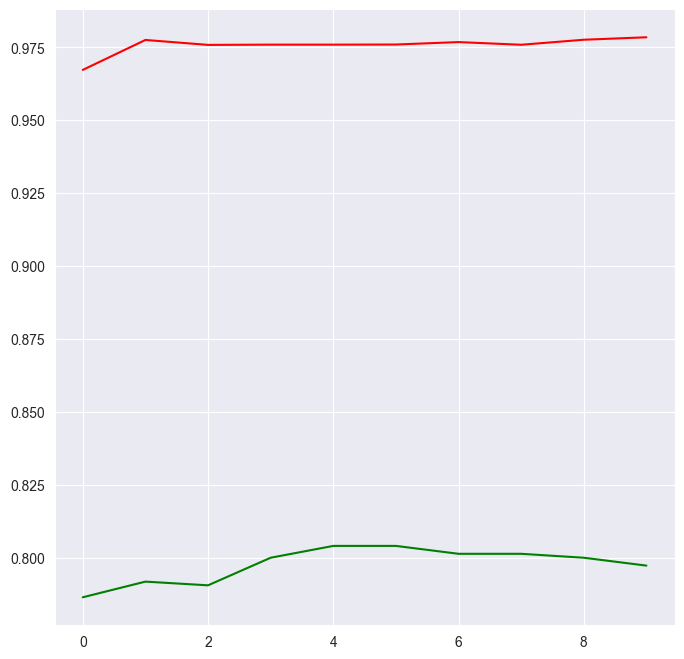

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(valid_f1, c="green")
plt.plot(train_f1, c="red")

In [22]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_leaf=5, min_samples_split=15, max_features='sqrt')
rf.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",15
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [23]:
print(classification_report(y_test, rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       130
           1       0.76      0.74      0.75       126

    accuracy                           0.75       256
   macro avg       0.75      0.75      0.75       256
weighted avg       0.75      0.75      0.75       256



## Confusion Matrix

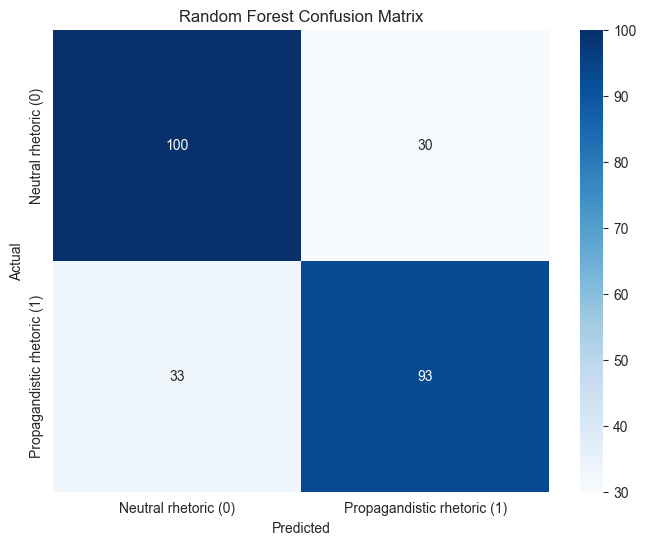

In [25]:
from  sklearn. metrics._classification import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_prediction = rf.predict(x_test)
cm = confusion_matrix(y_test, test_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Neutral rhetoric (0)', 'Propagandistic rhetoric (1)'], 
            yticklabels=['Neutral rhetoric (0)', 'Propagandistic rhetoric (1)'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()